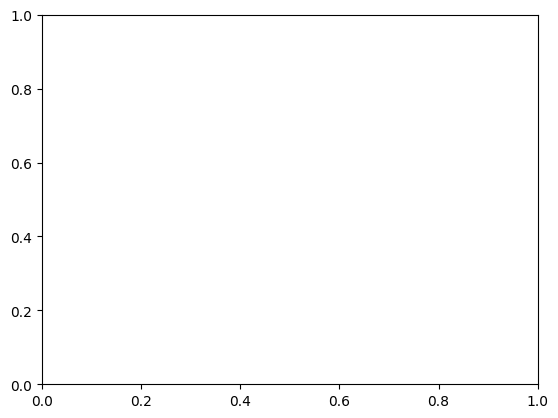

In [2]:
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from oceantracker.post_processing.read_output_files.load_output_files import load_track_data
from oceantracker.post_processing.read_output_files.load_output_files import get_case_info_files_from_dir
from oceantracker.post_processing.read_output_files.load_output_files import read_case_info_file
from oceantracker.post_processing.read_output_files.load_output_files import load_concentration_data

from oceantracker.post_processing.transect_projection.transect import Transect

from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_particle_prop
from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_fraction_above_threshold
from oceantracker.post_processing.plotting.plot_collapse import hexmap_of_death


from oceantracker.post_processing.plotting.plot_collapse import plot_depth_along_transect
from oceantracker.post_processing.plotting.plot_collapse import plot_part_prop_along_transect
from oceantracker.post_processing.plotting.plot_collapse import plot_relative_depth_along_transect

from oceantracker.post_processing.plotting.plot_tracks import animate_particles

#cm
import matplotlib.cm as cm

## tmp

In [11]:
#%% 

import numpy as np
import pandas as pd
from oceantracker import main


#-----------------------------------------------    
run_name = '22_11_01_depth_losses_v54'
#-----------------------------------------------


# v10
# upgraded from ot v03 to v04

# v11
# reduced release pulse interval as buffer is overflowing

# v12
# full year instead of 3 months and buffer increase to find equilibrium pop.

# v13
# small demo version (1 month) with hourly output

# v14
# trying to add turbidity to the model      
# reducing particles and model time to speed up testing

# v15
# adding average illumination to the model

# v16
# addingTurbidityInducedPrecipitationLikeSinking
# pleanty of debugging and getting everything to work

# v17
# adding illumination based culling

# v18
# adding particle radius, density to calculate
# a terminal velocity based on stokes law
# with density and radius being changed by particles
# colliding with SPM particles and sticking to them

# v20
# merged dev041 to fix vertical diffusion bug

# v21
# using hzg3 containing montly averaged spm fields
# 1month run with 60s output

# v22
# testing new multi case run
# SA for initial particle size and stickiness

# v23
# small fixing and debugging run

# v28
# based on v23 after identifying a bug in regridding

# v29
# added the grid workaround again. has not been fixed as assumed
# also removed emtpy case from case list 
# removed unnecessary fields from the output

# v30
# adding "cause_of_death"

# v31
# "bigger" run with light limitation induced mortality
# using a 12 day average (to fit the)

# v32
# using fractal radius for sinking 
# care - turned out to be buggy

# v33
# restructuring the spherical/fractal radius and density
# to be more flexible aka be turned on or off
# v33 is spherical

# v34
# fractal collission and buoyancy

# v35
# based on v33 without dyn dispersion

# v36
# full year run

# v37
# fixed cull intervall (1/60s instead of 1/1d)

# v38
# increased stickiness resolution to 0.01

# v39 (bugged it think)
# new dataset with tke diss
# added curvilinear shear kernel for coagulation

# v40
# fixed coagulation rates

# v41
# added differential sedimentation kernel

# v42
# comparison run with BAWs sedimorphs sinking 

# v43
# increased initial size to 100mu

# v44
# back to kriest sinking with a 100mu

# v45
# 50mu initial size

# v46
# test run for v47

# v47
# "new" case lists testing the full range of parameters for the paper

# v48
# debugging run for v47

# v49
# v47/48 with more cases and larger SA range

# v50
# more cases

# v51 
# moving to levante for (close to) final runs


# input_dir = "/scratch/local1/hzg4/"
# output_dir = "/scratch/local1/output/"
input_dir = "/work/uh0296/u301513/hydrodynamics_data/hzg_tkediss_spm/"
output_dir = "/work/uh0296/u301513/ot_output/"

# tweeked parameters:



release_polygon = [
    # old - upstream of weir
    # {
    #     'points': np.array([
	# 				[593043,5919010],
    #                 [592988,5919053],
	# 				[592924,5918944],
	# 				[592981,5918899]
    #     ])
    # }
    # new - downstream of weir
    {
        'points': np.array([
            [588957, 5920789],
            [588523, 5920773],
            [588442, 5919759],
            [589038, 5919759],
        ])
    }
]

observational_polygons = [
    {
        'points': np.array([
            # zollenspieker
            [578503, 5917114],
            [578341, 5917110],
            [578291, 5916941],
            [578447, 5916941],
        ])
    },
    {
        'points': np.array([
            # seemanshöft
            [558344, 5933147],
            [558107, 5933176],
            [558031, 5932881],
            [558269, 5932847],
        ])
    }
]


params={
    "root_output_dir": output_dir,
    "output_file_base": run_name,
    "debug": False,
    "processors": 256,

    "regrid_z_to_uniform_sigma_levels": False,

    # "run_params":
    "write_tracks": True,
    # "max_run_duration": 3600*24*1,
    "max_particles": int(1e6),
    "open_boundary_type": 0,
    "block_dry_cells": True,
    "time_step": 60,
    "screen_output_time_interval": 24*3600,
    "write_dry_cell_flag": True,

	"reader": {
		"input_dir": input_dir,
		"file_mask": "schout_*.nc",
        "load_fields": [
            "turbidity",
            "spm_sum_of_all_classes",
            "spm_very_fine_silt",
            "spm_fine_silt",
            "spm_medium_silt",
            "spm_coarse_silt",
            "spm_very_fine_sand",
            "salinity",
            "TKE_dissipation_rate"
        ],
		"field_variable_map": {
			"water_depth": "depth",
			"salinity": "salt",
            "turbidity": "spm_sum_of_all_classes",
            "spm_sum_of_all_classes": "spm_sum_of_all_classes",
            "spm_very_fine_silt": "spm_very_fine_silt",
            "spm_fine_silt": "spm_fine_silt",
            "spm_medium_silt": "spm_medium_silt",
            "spm_coarse_silt": "spm_coarse_silt",
            "spm_very_fine_sand": "spm_very_fine_sand",
            "A_Z_profile": "diffusivity",
            "TKE_dissipation_rate": "TKE_dissipation_rate"
		},
	},

    "solver": {
        "RK_order": 2,
    },

    "dispersion": {
        'class_name': 'oceantracker.dispersion.random_walk_varyingAz.RandomWalkVaryingAZ',
        "A_H": 0.1,
        # "A_V": 0.001
    },

    "particle_properties": {  

        "dryout": {
            "class_name": "oceantracker.particle_properties.stranded_dryout.StrandedDryout",
            "max_time_stranded": 3600*24*1
        },
        "illumination": {
            'class_name': 'oceantracker.particle_properties.illumination.AverageIllumination',
            'name_of_turbidity_field': 'spm_sum_of_all_classes',
            'name_of_irradiance_field': 'irradiance',
            'c': 5,
            'time_to_average': 24*3600*12,
            'initial_value': 30,
        },
        "cause_of_death": {
            "class_name": "oceantracker.particle_properties.cause_of_death.CauseOfDeath",
        },
    },

    "fields": {
        "irradiance": {
            'class_name': 'oceantracker.fields.irradiance.Irradiance',
            'name_of_field': 'spm_sum_of_all_classes',
            'latitude': 53.5,
            'longitude': 9.9,
            'timezone': 'UTC',
            'albedo': 0.1
        },
    }, 

    "resuspension": {
        "critical_friction_velocity": 0.009
    },
    
    "trajectory_modifiers": {
        "salinity_induced_mortality": {
            "class_name": "oceantracker.trajectory_modifiers.cull_particles.ParticleCullConcentration",
            "cull_interval": 60,
            "cull_status_greater_than": "dead",
            "threshold_to_cull": 10,
            "probability_of_culling": 1,
            "concentration_field": "salinity"
        },
    },
    "velocity_modifiers": {
            "buyoancy_based_terminal_velocity": {
            "class_name": "oceantracker.velocity_modifiers.buoyancy_based_terminal_velocity.BuoyancyBasedTerminalVelocity"
            }
        },

    "release_groups": {
        "poly1": {
            "class_name": "oceantracker.release_groups.polygon_release.PolygonRelease",
            "points": release_polygon[0]['points'],
            "pulse_size": 1,
            "release_interval": 3600
        }
    },
    "tracks_writer": {
        "update_interval": int(3600*24),
        "turn_off_write_particle_properties_list": [
                    
                    # default
                    "water_velocity",
                    "particle_velocity",
                    "velocity_modifier"

                    # manually added
                    "x_last_good",
                    "age",
                    "turbidity",
                    "spm_very_fine_sand",
                    "spm_very_fine_silt",
                    "tide",
                    "water_depth",
                    "spm_medium_silt",
                    "salinity",
                    "spm_coarse_silt",
                    "spm_fine_silt",
                    "spm_sum_of_all_classes",
                    "irradiance",
                    "density_spherical",
                    "buoyancy",
                    "radius_spherical",
                    "collision_very_fine_silt",
                    "collision_fine_silt",
                    "collision_medium_silt",
                    "collision_coarse_silt",
                    "collision_very_fine_sand",
                    "dryout",
                    "illumination",
                    "TKE_dissipation_rate",
                ],
        # "time_steps_per_per_file": 24,
    },
    'particle_concentrations': {
            "top_layer": {
                "class_name": 'oceantracker.particle_concentrations.particle_concentrations.ParticleConcentrationsDepthLayer',
                "update_interval": 24*3600,
                "layer_depth_min": 1,
                "layer_depth_max": 2
            },
            "full_coloumn": {
                "class_name": 'oceantracker.particle_concentrations.particle_concentrations.ParticleConcentrations2D',
                "update_interval": 24*3600,
                "layer_depth_min": 1,
                "layer_depth_max": 2
            }
    },
}



df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

# stickiness from 0 to 1 in 10 steps for initial size 1e-5/2 light threshold of 30 and culling of 3.56e-05 
for stickiness in np.zeros(128):
    # for initial_size_list in [1e-5, 5e-5, 1e-4]:
    for initial_size_list in [5e-5]:
        df = pd.concat([df, pd.DataFrame({'initial_size': initial_size_list,
                                 'stickiness': stickiness,
                                 'light_limitation_threshold': 30,
                                 'light_limited_culling_prop': 3.56e-05}, index=[0])
                                 ])

# stickiness of 1 1e-5 light threshold of 15,30,60 and culling of 3.56e-05
# for light_limitation_threshold in np.linspace(10, 100, 5):
#     df = pd.concat([df, pd.DataFrame({'initial_size': 5e-5,
#                                  'stickiness': 1,
#                                  'light_limitation_threshold': light_limitation_threshold,
#                                  'light_limited_culling_prop': 3.56e-05}, index=[0])
#                                  ])
# # stickiness of 1 1e-5 light threshold of 30 and culling of 3.56e-05/2, 3.56e-05, 3.56e-05*2
# for light_limited_culling_prop in np.linspace(3.56e-06, 3.56e-04, 5):
#     df = pd.concat([df, pd.DataFrame({'initial_size': 5e-5,
#                                  'stickiness': 1,
#                                  'light_limitation_threshold': 30,
#                                  'light_limited_culling_prop': light_limited_culling_prop}, index=[0])
#                                  ])

# reindex
df = df.reset_index(drop=True)
df

/tmp/ipykernel_28324/1376547166.py:367: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({'initial_size': initial_size_list,


,initial_size,stickiness,light_limitation_threshold,light_limited_culling_prop
0,0.00005,0.0,30,0.000036
1,0.00005,0.0,30,0.000036
2,0.00005,0.0,30,0.000036
3,0.00005,0.0,30,0.000036
4,0.00005,0.0,30,0.000036
...,...,...,...,...
123,0.00005,0.0,30,0.000036
124,0.00005,0.0,30,0.000036
125,0.00005,0.0,30,0.000036
126,0.00005,0.0,30,0.000036


In [10]:
np.ones((128)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
#
# x = [586.0629921259842, 593.3858267716536, 598.3464566929134, 603.0708661417323, 608.0314960629921, 610.1574803149606, 613.9370078740158, 616.5354330708661, 617.7165354330708, 618.6614173228346, 619.8425196850394, 620.7874015748032, 621.7322834645669, 624.0944881889764, 624.5669291338583, 625.9842519685039, 627.6377952755905, 629.7637795275591, 631.1811023622047, 632.8346456692914, 634.0157480314961, 637.7952755905512, 641.5748031496063, 643.9370078740158, 647.007874015748, 647.9527559055118, 651.496062992126, 654.5669291338583, 658.5826771653543, 660.4724409448819, 665.9055118110236, 670.8661417322835, 672.2834645669291, 676.0629921259842, 679.8425196850394, 681.732283464567, 692.5984251968504, 694.488188976378, 700.3937007874016, 705.5905511811023, 707.9527559055118, 712.6771653543307, 717.1653543307086, 722.3622047244095, 724.7244094488188]
# y = [140.41666666666669, 138.75, 136.66666666666669, 134.16666666666669, 130, 123.75, 117.5, 110.83333333333334, 103.75, 97.91666666666667, 91.66666666666667, 84.16666666666667, 76.25, 71.66666666666667, 65, 56.66666666666667, 50.41666666666667, 43.333333333333336, 36.25, 28.75, 23.333333333333336, 20.833333333333336, 19.166666666666668, 15.833333333333334, 15, 11.666666666666668, 10, 7.5, 7.5, 5, 5, 5, 4.583333333333334, 4.583333333333334, 4.583333333333334, 5.416666666666667, 5.416666666666667, 6.25, 6.25, 6.666666666666667, 7.083333333333334, 7.5, 7.5, 7.916666666666667, 8.333333333333334]

chloropyll_schoell = np.array([
    [586.06, 140.42],
    [593.39, 138.75],
    [598.35, 136.67],
    [603.07, 134.17],
    [608.03, 130.0],
    [610.16, 123.75],
    [613.94, 117.5],
    [616.54, 110.83],
    [617.72, 103.75],
    [618.66, 97.92],
    [619.84, 91.67],
    [620.79, 84.17],
    [621.73, 76.25],
    [624.09, 71.67],
    [624.57, 65.0],
    [625.98, 56.67],
    [627.64, 50.42],
    [629.76, 43.33],
    [631.18, 36.25],
    [632.83, 28.75],
    [634.02, 23.33],
    [637.79, 20.83],
    [641.57, 19.17],
    [643.94, 15.83],
    [647.01, 15.0],
    [647.95, 11.67],
    [651.5, 10.0],
    [654.57, 7.5],
    [658.58, 7.5],
    [660.47, 5.0],
    [665.91, 5.0],
    [670.87, 5.0],
    [672.28, 4.58],
    [676.06, 4.58],
    [679.84, 4.58],
    [681.73, 5.42],
    [692.6, 5.42],
    [694.49, 6.25],
    [700.39, 6.25],
    [705.59, 6.67],
    [707.95, 7.08],
    [712.68, 7.5],
    [717.17, 7.5],
    [722.36, 7.92],
    [724.72, 8.33]

])
# x = [585, 585, 584.8888888888889, 587, 587.6666666666666, 588.5555555555555, 589.6666666666666, 590.5555555555555, 591.7777777777778, 592.3333333333334, 593.5555555555555, 594.8888888888889, 595.3333333333334, 596.4444444444445, 597.3333333333334, 598.1111111111111, 598.4444444444445, 599.3333333333334, 600.5555555555555, 601, 602.4444444444445, 603.5555555555555, 604.7777777777778, 605.6666666666666, 607.4444444444445, 608.5555555555555, 609.7777777777778, 610.5555555555555, 611.3333333333334, 613.2222222222222, 613.8888888888889, 614.8888888888889, 615.3333333333334, 616.2222222222222, 617.5555555555555, 618.7777777777778, 619.6666666666666, 620.3333333333334, 621.8888888888889, 622.6666666666666, 623.3333333333334, 624.8888888888889, 625.8888888888889, 626, 626.6666666666666, 628.8888888888889, 629.2222222222222, 632, 632.6666666666666, 633.1111111111111, 633.3333333333334, 634.1111111111111, 634.5555555555555, 636, 636.3333333333334, 637.5555555555555, 639.2222222222222, 640.6666666666666, 642.1111111111111, 642.7777777777778, 643.7777777777778, 644.8888888888889, 645.7777777777778, 647.2222222222222, 648.4444444444445, 649.6666666666666, 650.7777777777778, 651.8888888888889, 652.6666666666666, 653.8888888888889, 656, 656.7777777777778, 657.4444444444445, 658.6666666666666, 659.6666666666666, 660.7777777777778, 661.7777777777778, 662.3333333333334, 664, 664.8888888888889, 665.8888888888889, 666.7777777777778, 667.7777777777778, 668.8888888888889, 669.8888888888889, 670.4444444444445, 672.2222222222222, 673.8888888888889, 674.6666666666666, 675.7777777777778, 676.5555555555555, 677.8888888888889, 679, 680, 680.6666666666666, 681.8888888888889, 682.8888888888889, 683.8888888888889, 685.2222222222222, 685.7777777777778, 686.8888888888889, 687.8888888888889, 688.8888888888889, 690, 691.2222222222222, 692.2222222222222, 693.2222222222222, 693.5555555555555, 694.4444444444445, 695.4444444444445, 697, 698, 699.3333333333334, 700.2222222222222, 701.1111111111111, 702.2222222222222, 703.3333333333334, 704.1111111111111, 705.1111111111111, 705.6666666666666, 707.1111111111111, 708.2222222222222, 709, 710.2222222222222, 711.1111111111111, 711.7777777777778, 713.3333333333333, 714, 714.8888888888889, 716, 717, 718.1111111111111, 718.7777777777778, 720, 721, 722, 722.7777777777778, 723.8888888888889, 724.8888888888889, 725.7777777777778, 726.7777777777778, 603]
# y = [-20.052219321148826, -20.052219321148826, -3.8120104438642315, -3.70757180156658, -4.438642297650132, -4.908616187989557, -3.603133159268932, -3.9164490861618795, -3.9164490861618795, -4.334203655352482, -4.020887728459531, -3.8642297650130573, -4.281984334203656, -3.550913838120106, -3.1331592689295036, -3.1853785900783294, -4.281984334203656, -4.490861618798956, -4.2297650130548305, -4.751958224543081, -4.464751958224545, -4.83028720626632, -4.046997389033944, -5.195822454308095, -5.45691906005222, -4.412532637075719, -3.8381201044386444, -4.308093994778069, -4.5691906005221945, -4.6214099216710185, -3.9425587467362924, -4.464751958224545, -5.143603133159269, -5.509138381201046, -5.195822454308095, -4.516971279373369, -7.284595300261097, -8.433420365535248, -8.433420365535248, -7.5456919060052225, -10.835509138381202, -10.731070496083552, -11.201044386422977, -14.12532637075718, -11.044386422976501, -10.992167101827677, -13.28981723237598, -13.394255874673629, -8.798955613577023, -8.433420365535248, -9.321148825065274, -9.47780678851175, -11.096605744125327, -11.409921671018278, -12.193211488250654, -10.678851174934726, -10.365535248041777, -9.7911227154047, -10.104438642297652, -8.537859007832898, -7.859007832898174, -8.694516971279374, -9.89556135770235, -8.485639686684074, -11.932114882506529, -11.044386422976501, -9.321148825065274, -10.939947780678851, -10.156657963446476, -10, -10.208877284595301, -9.5822454308094, -10.261096605744125, -10.261096605744125, -9.26892950391645, -10, -8.537859007832898, -12.402088772845953, -12.558746736292429, -12.97650130548303, -10.574412532637076, -11.044386422976501, -8.694516971279374, -9.112271540469974, -8.328981723237598, -10, -9.947780678851176, -9.947780678851176, -10.4177545691906, -10.574412532637076, -10.104438642297652, -6.292428198433422, -7.127937336814622, -7.597911227154048, -9.738903394255875, -11.305483028720626, -9.89556135770235, -9.5822454308094, -9.68668407310705, -10.731070496083552, -12.45430809399478, -11.566579634464752, -11.932114882506529, -10.208877284595301, -9.68668407310705, -9.530026109660575, -9.7911227154047, -12.45430809399478, -12.819843342036554, -13.394255874673629, -12.402088772845953, -12.767624020887729, -12.872062663185378, -11.775456919060053, -9.1644908616188, -9.7911227154047, -9.425587467362925, -9.530026109660575, -10.574412532637076, -11.827676240208877, -11.879895561357703, -12.297650130548304, -11.514360313315928, -8.381201044386424, -11.618798955613578, -9.321148825065274, -9.321148825065274, -8.224543080939949, -8.7467362924282, -7.441253263707573, -14.22976501305483, -11.148825065274153, -10.939947780678851, -11.566579634464752, -12.610966057441253, -9.738903394255875, -10.104438642297652, -10.626631853785902, -11.723237597911227, -14.073107049608355, -15.013054830287206, -9.321148825065274]

mean_deapth_schoel = np.array([
    [584.89, -3.81],
    [587, -3.71],
    [587.67, -4.44],
    [588.56, -4.91],
    [589.67, -3.60],
    [590.56, -3.92],
    [591.78, -3.92],
    [592.33, -4.33],
    [593.56, -4.02],
    [594.89, -3.86],
    [595.33, -4.28],
    [596.44, -3.55],
    [597.33, -3.13],
    [598.11, -3.18],
    [598.44, -4.28],
    [599.33, -4.49],
    [600.11, -4.23],
    [600.56, -4.75],
    [602.44, -4.46],
    [603.56, -4.83],
    [604.78, -4.05],
    [605.67, -5.19],
    [607.44, -5.46],
    [608.56, -4.41],
    [609.78, -3.83],
    [610.56, -4.31],
    [611.33, -4.57],
    [613.22, -4.62],
    [613.89, -3.94],
    [614.89, -4.46],
    [615.33, -5.14],
    [616.22, -5.50],
    [617.56, -5.20],
    [618.78, -4.52],
    [619.67, -7.28],
    [620.33, -8.43],
    [621.88, -8.43],
    [622.67, -7.55],
    [623.33, -10.84],
    [624.22, -10.73],
    [625.56, -11.20],
    [626.44, -14.12],
    [627.33, -11.04],
    [628.11, -10.99],
    [628.44, -13.28],
    [629.33, -13.39],
    [630.00, -8.79],
    [630.33, -8.43],
    [631.56, -9.32],
    [632.22, -9.47],
    [633.11, -11.09],
    [633.55, -11.41],
    [634.44, -12.19],
    [636.00, -10.68],
    [636.33, -10.36],
    [637.55, -9.79],
    [639.22, -10.10],
    [640.67, -8.54],
    [642.11, -7.86],
    [642.78, -8.69],
    [643.78, -9.89],
    [644.89, -8.49],
    [645.78, -11.93],
    [647.22, -11.04],
    [648.44, -9.32],
    [649.67, -10.94],
    [650.78, -10.16],
    [651.89, -10.00],
    [652.67, -10.21],
    [653.89, -9.58],
    [656.00, -10.26],
    [656.78, -10.26],
    [657.44, -9.27],
    [658.67, -10.00],
    [659.67, -8.54],
    [660.78, -12.40],
    [661.78, -12.56],
    [662.98, -12.98],
    [664.00, -10.57],
    [664.89, -11.04],
    [665.78, -8.69],
    [666.67, -9.11],
    [668.33, -8.32],
    [670.00, -10.00],
    [670.94, -9.95],
    [671.89, -9.95],
    [672.22, -10.42],
    [673.11, -10.57],
    [674.10, -10.10],
    [676.29, -6.29],
    [677.13, -7.13],
    [678.60, -7.60],
    [680.00, -9.74],
    [681.31, -11.30],
    [682.89, -9.89],
    [683.58, -9.58],
    [684.69, -9.69],
    [685.78, -10.73],
    [687.11, -12.45],
    [688.11, -11.57],
    [688.78, -11.93],
    [690.21, -10.21],
    [691.22, -9.69],
    [692.22, -9.53],
    [693.22, -9.79],
    [693.56, -12.45],
    [694.44, -12.82],
    [695.44, -13.39],
    [697.00, -12.40],
    [698.00, -12.77],
    [699.33, -12.87],
    [700.22, -11.78],
    [701.11, -9.16],
    [702.22, -9.79],
    [703.33, -9.43],
    [704.11, -9.53],
    [705.11, -10.57],
    [705.67, -11.83],
    [707.11, -11.88],
    [708.22, -12.29],
    [709.11, -11.51],
    [710.78, -8.38],
    [711.62, -11.62],
    [711.88, -9.32],
    [713.33, -9.32],
    [714.22, -8.22],
    [714.89, -8.75],
    [716.44, -7.44],
    [718.22, -14.22],
    [718.88, -11.14],
    [720.11, -10.93],
    [721.00, -11.57],
    [722.00, -12.61],
    [722.78, -9.74],
    [723.33, -10.10],
    [723.89, -10.63],
    [724.88, -11.72],
    [725.78, -14.07],
    [726.78, -15.01],
])
    

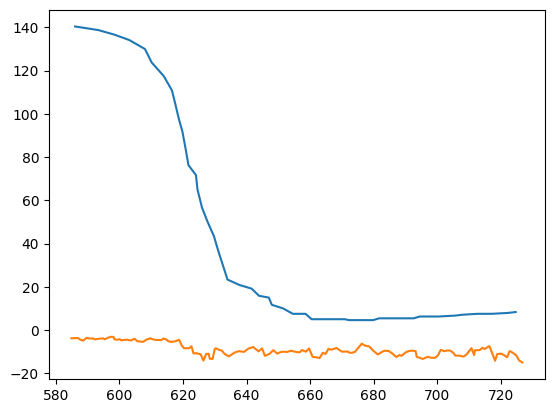

In [4]:
plt.plot(chloropyll_schoell[:,0], chloropyll_schoell[:,1], label="Chlorophyll")
plt.plot(mean_deapth_schoel[:,0], mean_deapth_schoel[:,1], label="Mean depth")

[(0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.984313725490196, 0.6039215686274509, 0.6)]

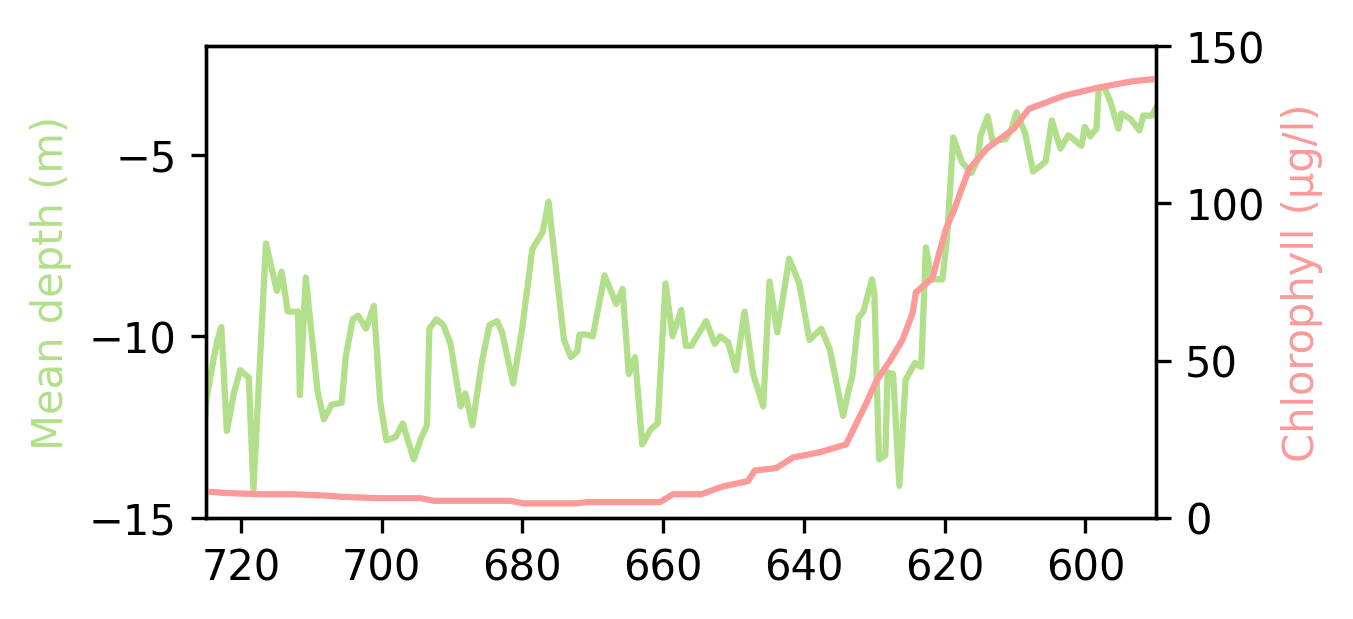

In [16]:
# creating figure with two y-axis
# first y-axis is chlorophyll, second y-axis is turbidity

colors = [sns.color_palette("Paired")[2],  sns.color_palette("Paired")[4]]

fig,ax1 = plt.subplots(figsize=(12/2.53, (8.3*0.66)/2.53), dpi=300,)
ax2 = ax1.twinx()


ax1.plot(mean_deapth_schoel[:,0], mean_deapth_schoel[:,1], label="Mean depth",color=colors[0])
# ylabel
ax1.set_ylabel('Mean depth (m)', color=colors[0])
# ylim 0,20
ax1.set_ylim(-15,-2)

ax2.plot(chloropyll_schoell[:,0], chloropyll_schoell[:,1], label="Chlorophyll",color=colors[1])
# ylabel
ax2.set_ylabel('Chlorophyll (µg/l)', color=colors[1])
# ylim 0,150
ax2.set_ylim(0,150)


# xlim  from 580, 730
ax1.set_xlim(590,725)

# grid major gray dashed
# ax1.grid(which='major', linestyle='--', color='gray',alpha=0.2,zorder=0)

# tight layout
fig.tight_layout()

# invert x-axis
ax1.invert_xaxis()

# savefig
fig.savefig('chl_depth.png',dpi=300)




In [2]:
def slice_and_fill_subset(df,indices,cases):
    for ii in indices:
        # print(len(cases))
        # print(ii)
        # print within the same line and overwrite each time the loop runs again
        print(f'\rProcessing case: {ii:03}/{len(cases):03}', end='', flush=True)
        

        case = cases[ii]

    # check if a column with 'died_by_salinity' exists
        if 'died_by_salinity' not in df.columns:
        # add columns
            df['died_by_salinity'] = np.nan
            df['died_by_depth'] = np.nan
            df['died_by_stranding'] = np.nan
            df['died_in_total'] = np.nan


    # test if "died_by_stranding" is not nan for that row
        if np.isnan(df.loc[ii, 'died_by_stranding']):
            track_data = load_track_data(case)

            cause_of_death = track_data['cause_of_death']
            cause_of_death = cause_of_death[-1,:]

            cause_of_death_without_survivers = cause_of_death[cause_of_death != 0]
            cause_of_death_without_survivers = cause_of_death_without_survivers[~np.isnan(cause_of_death_without_survivers)]

            df.loc[ii, 'died_by_salinity'] = np.sum(cause_of_death_without_survivers == 1)
            df.loc[ii, 'died_by_depth'] = np.sum(cause_of_death_without_survivers == 2)
            df.loc[ii, 'died_by_stranding'] = np.sum(cause_of_death_without_survivers == 3)
            df.loc[ii, 'died_in_total'] = len(cause_of_death_without_survivers)
        # if ii > 2:
        #     break

# make a copy of the subset of the dataframe
    subset = df.loc[indices].copy()

# sort subset by stickiness
    subset = subset.sort_values(by='stickiness')

    return subset



def read_key_params_from_cases(cases):

    # reading cases and sorting thru them
    df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

    for ii, case in enumerate(cases):
        case_info = read_case_info_file(case)

        initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
        stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
        light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
        light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

        df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

    return df

In [3]:
# set context paper
sns.set_context("paper")

In [24]:
def plot_relative_cause_for_death(subset, variant='stickiness',save_path=None,color='colorblind'):
    # sns.set_palette(color, n_colors=3)

    colors = sns.color_palette(color, n_colors=3)
    # set font to roboto mono thin


    plt.figure(figsize=(8.3/2.53, (8.3/1.4)/2.53), dpi=300)
    # font size small for latex figure
    sns.set_context("paper", font_scale=0.8)

    # if value of subset[variant] is below 1e-3, then express it as percent
    if subset[variant].max() < 1e-3:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.stackplot(subset[variant],
                subset['died_by_stranding']/subset['died_in_total'],
                subset['died_by_depth']/subset['died_in_total'], 
                subset['died_by_salinity']/subset['died_in_total'],
                labels=['stranding','light limit.','salinity'], baseline='zero',
                colors=[colors[2], colors[1], colors[0]],
                hatch=['/', '-' ])
    # add white lines between the stacks
    plt.plot(subset[variant], subset['died_by_stranding']/subset['died_in_total'], color='white')
    plt.plot(subset[variant], subset['died_by_depth']/subset['died_in_total'] + subset['died_by_stranding']/subset['died_in_total'], color='white')
    
    # replace variant _ with " "
    variant_label = variant.replace("_", " ")
    plt.xlabel(variant_label)
    plt.ylabel('relative mortality')
    # plt.title('Stacked Line Plot with Stickyness on X-axis')
    plt.legend()

    plt.ylim(0,1)
    # make xlim snug to the min and max
    plt.xlim(subset[variant].min(), subset[variant].max())

    # # remove frame
    # sns.despine(bottom=True, left=True)
    # # make tick marks thinner and gray
    # plt.tick_params(width=0.5 , color='gray')

    # add gray grid
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

    # Get the handles and labels of the legend
    handles, labels = plt.gca().get_legend_handles_labels()

    # Reverse the order of the handles and labels
    handles = handles[::-1]
    labels = labels[::-1]

    # Create the reversed legend
    plt.legend(handles, labels)

    # save
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

## v51

In [7]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v51'

cases = get_case_info_files_from_dir(path_to_dir)
df = read_key_params_from_cases(cases)

### main stackplot

Processing case: 028/040

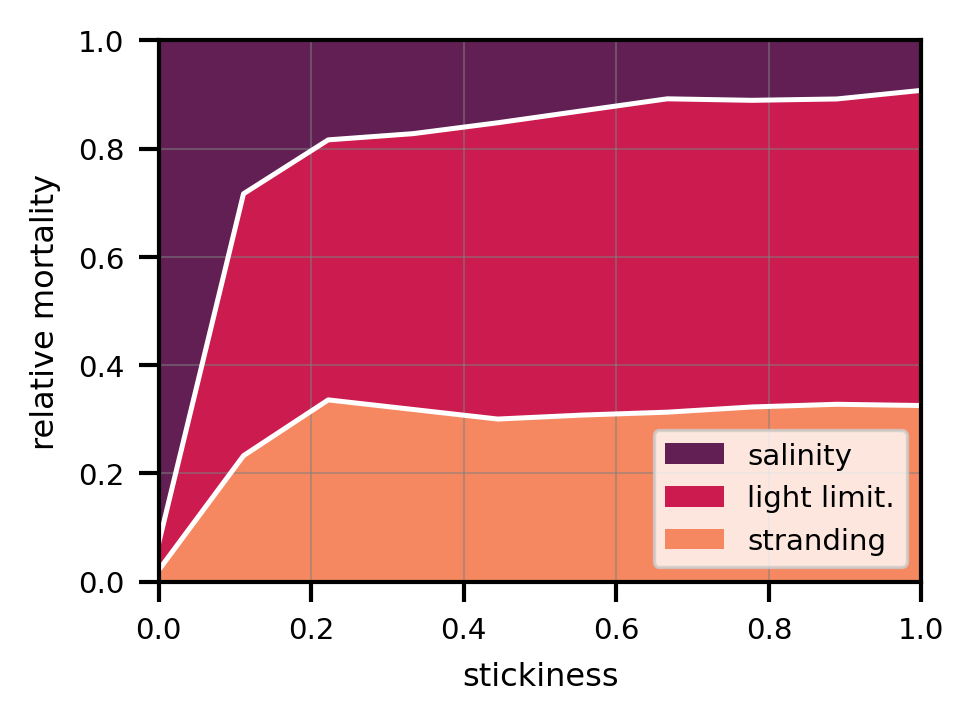

In [27]:
indices = df[(df['initial_size'] == 0.00005) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index
subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset, color="rocket")
                            #   save_path=f'rel_cause_of_death_main.png')


### SA size

Processing case: 028/040

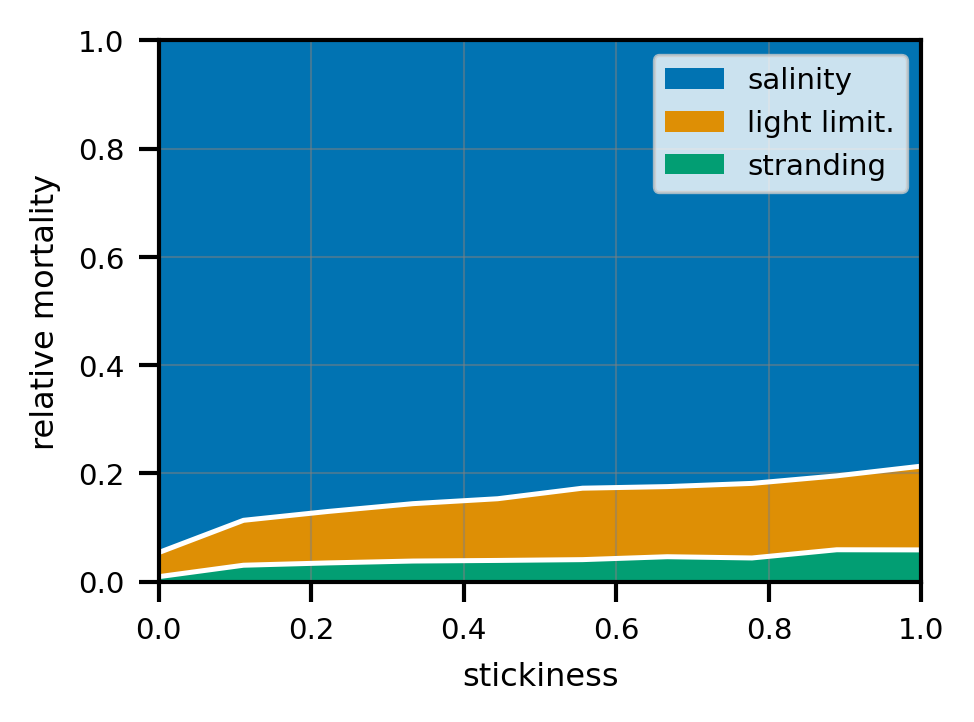

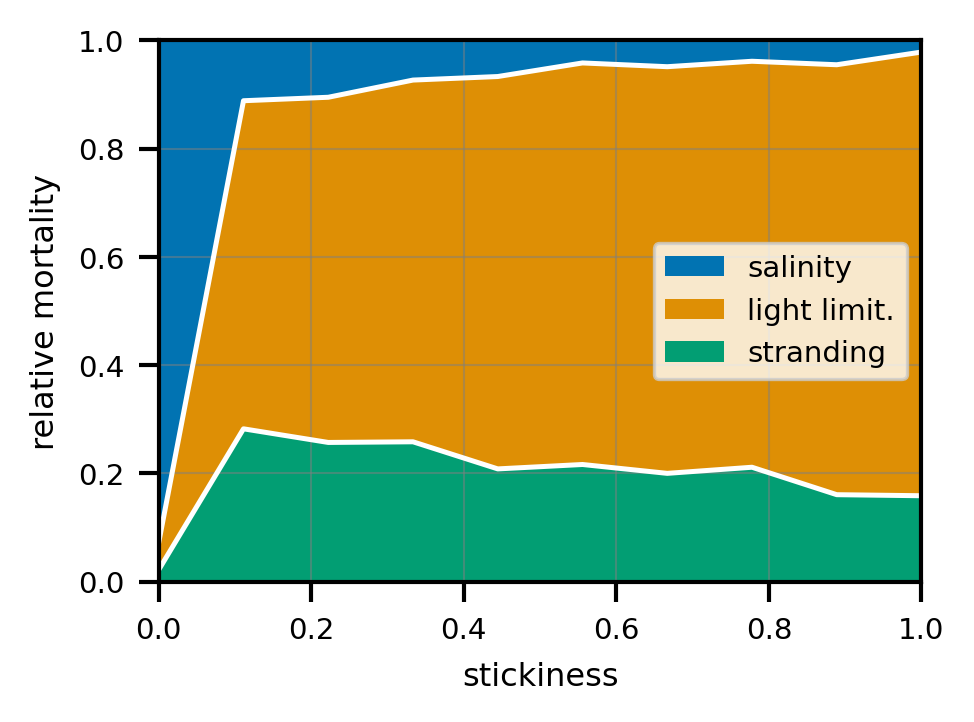

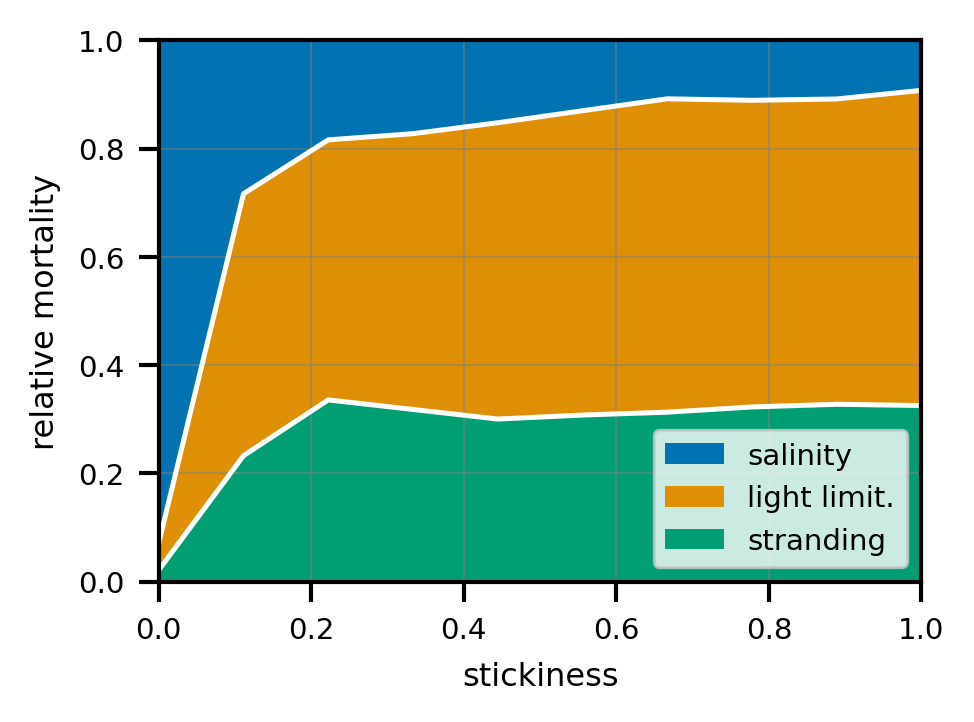

In [7]:
initial_sizes = set(df['initial_size'])

for size in initial_sizes:

    indices = df[(df['initial_size'] == size) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index
    subset = slice_and_fill_subset(df, indices, cases)
    # drop row 28


    filename = f'rel_cause_of_death_size_SA_{size:.0e}.png'
    
    plot_relative_cause_for_death(subset,save_path=filename)


### SA light limitation threshold 

Processing case: 034/040

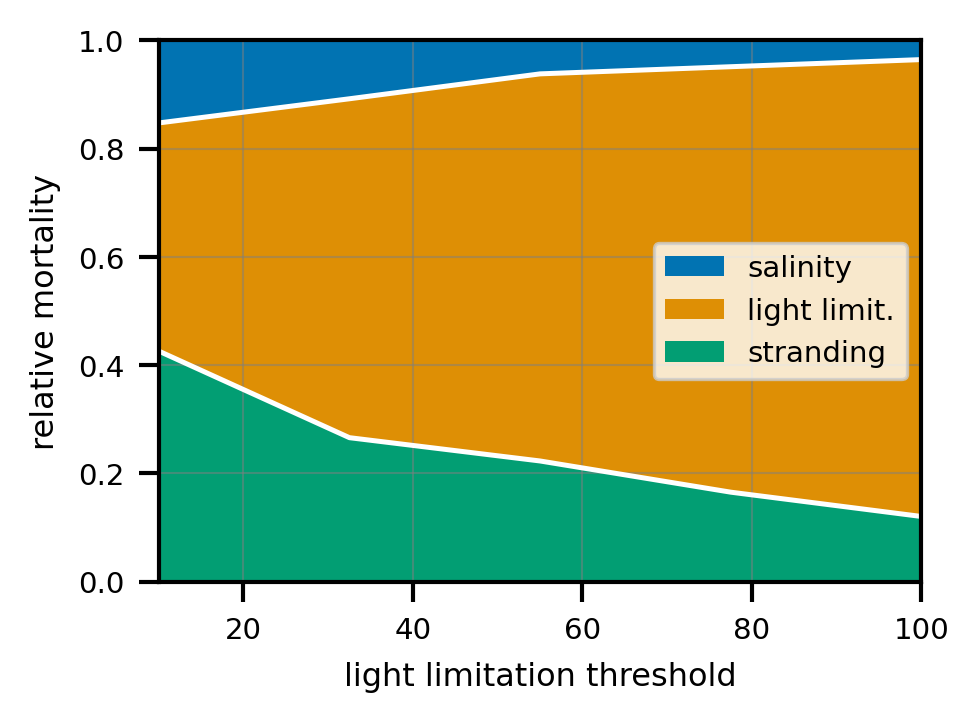

In [8]:
indices = df[(df['initial_size'] == 0.00005) & (df['stickiness'] == 1.000000) & (df['light_limited_culling_prop'] == 3.56e-05)].index
subset = slice_and_fill_subset(df, indices, cases)
# drop dublicates in column initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop and keep the last one
subset = subset.drop_duplicates(subset.columns.difference(['died_by_salinity', 'died_by_depth', 'died_by_stranding', 'died_in_total']), keep='last')
# drop first entry in subset
subset = subset.drop(subset.index[0])
# and sort by light_limitation_threshold
subset = subset.sort_values(by='light_limitation_threshold')

plot_relative_cause_for_death(subset, variant='light_limitation_threshold',save_path='rel_cause_of_death_SA_light_limit.png')

Processing case: 039/040

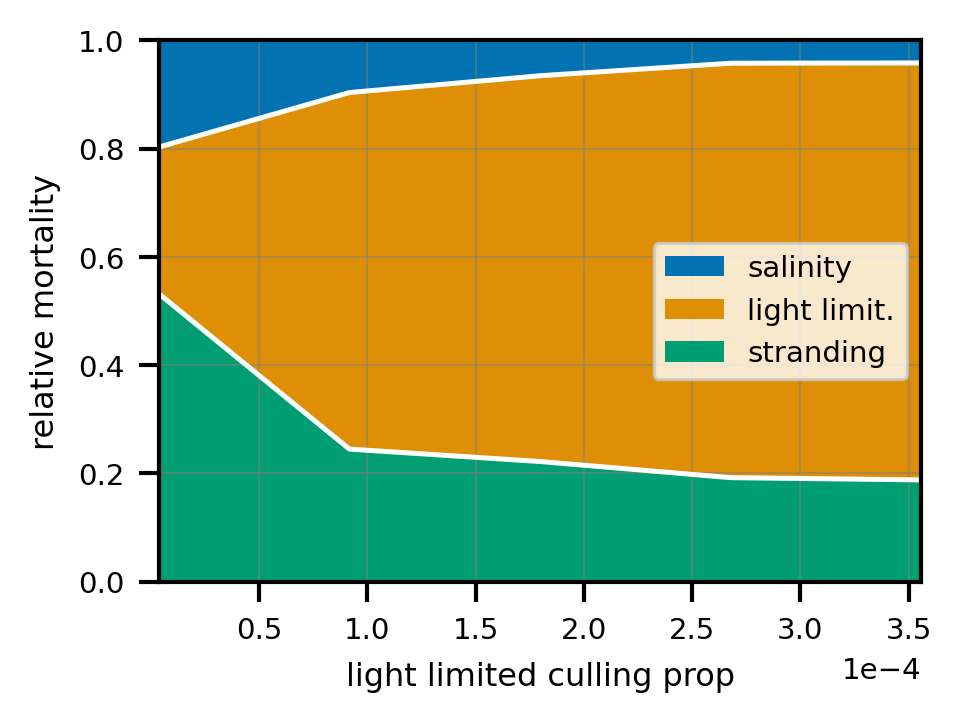

In [9]:
indices = df[(df['initial_size'] == 0.00005) & (df['stickiness'] == 1.000000) & (df['light_limitation_threshold'] == 30)].index
variant = "light_limited_culling_prop"

subset = slice_and_fill_subset(df, indices, cases)
# drop dublicates in column initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop and keep the last one
subset = subset.drop_duplicates(subset.columns.difference(['died_by_salinity', 'died_by_depth', 'died_by_stranding', 'died_in_total']), keep='last')
# drop first entry in subset
subset = subset.drop(subset.index[0])
# and sort by light_limitation_threshold
subset = subset.sort_values(by=variant)

plot_relative_cause_for_death(subset, variant=variant,save_path='rel_cause_of_death_SA_light_cull.png')


## location of death

In [10]:
df[   (df['initial_size'] == 0.00005) \
    & (df['stickiness']   == 1.000000) \
    & (df['light_limitation_threshold'] == 30)
    & (df['light_limited_culling_prop'] == 3.56e-05)].index[0]

28

2294


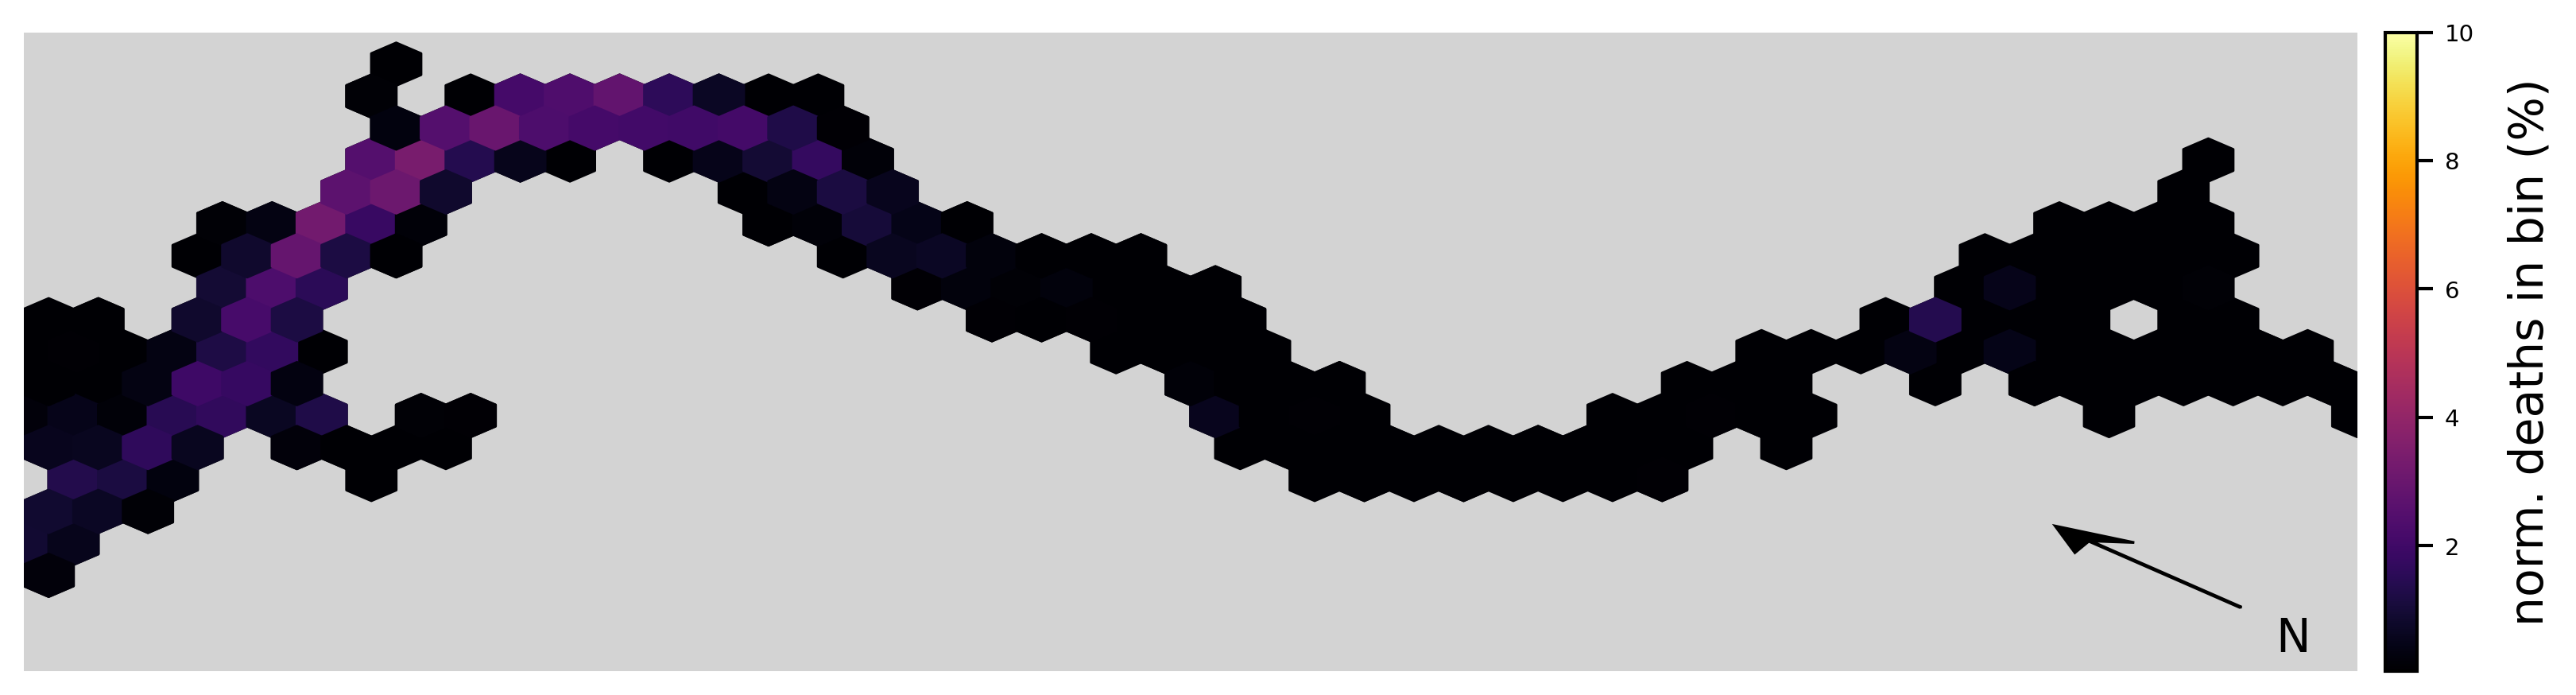

In [19]:
case_index = df[   (df['initial_size'] == 0.00005) \
    & (df['stickiness']   == 0.000000) \
    & (df['light_limitation_threshold'] == 30)
    & (df['light_limited_culling_prop'] == 3.56e-05)].index[0]


hexmap_of_death(case = cases[case_index],vmin=None,vmax=10,num_bins=10,save_path='hexmap_of_death_non_stick.png')

824


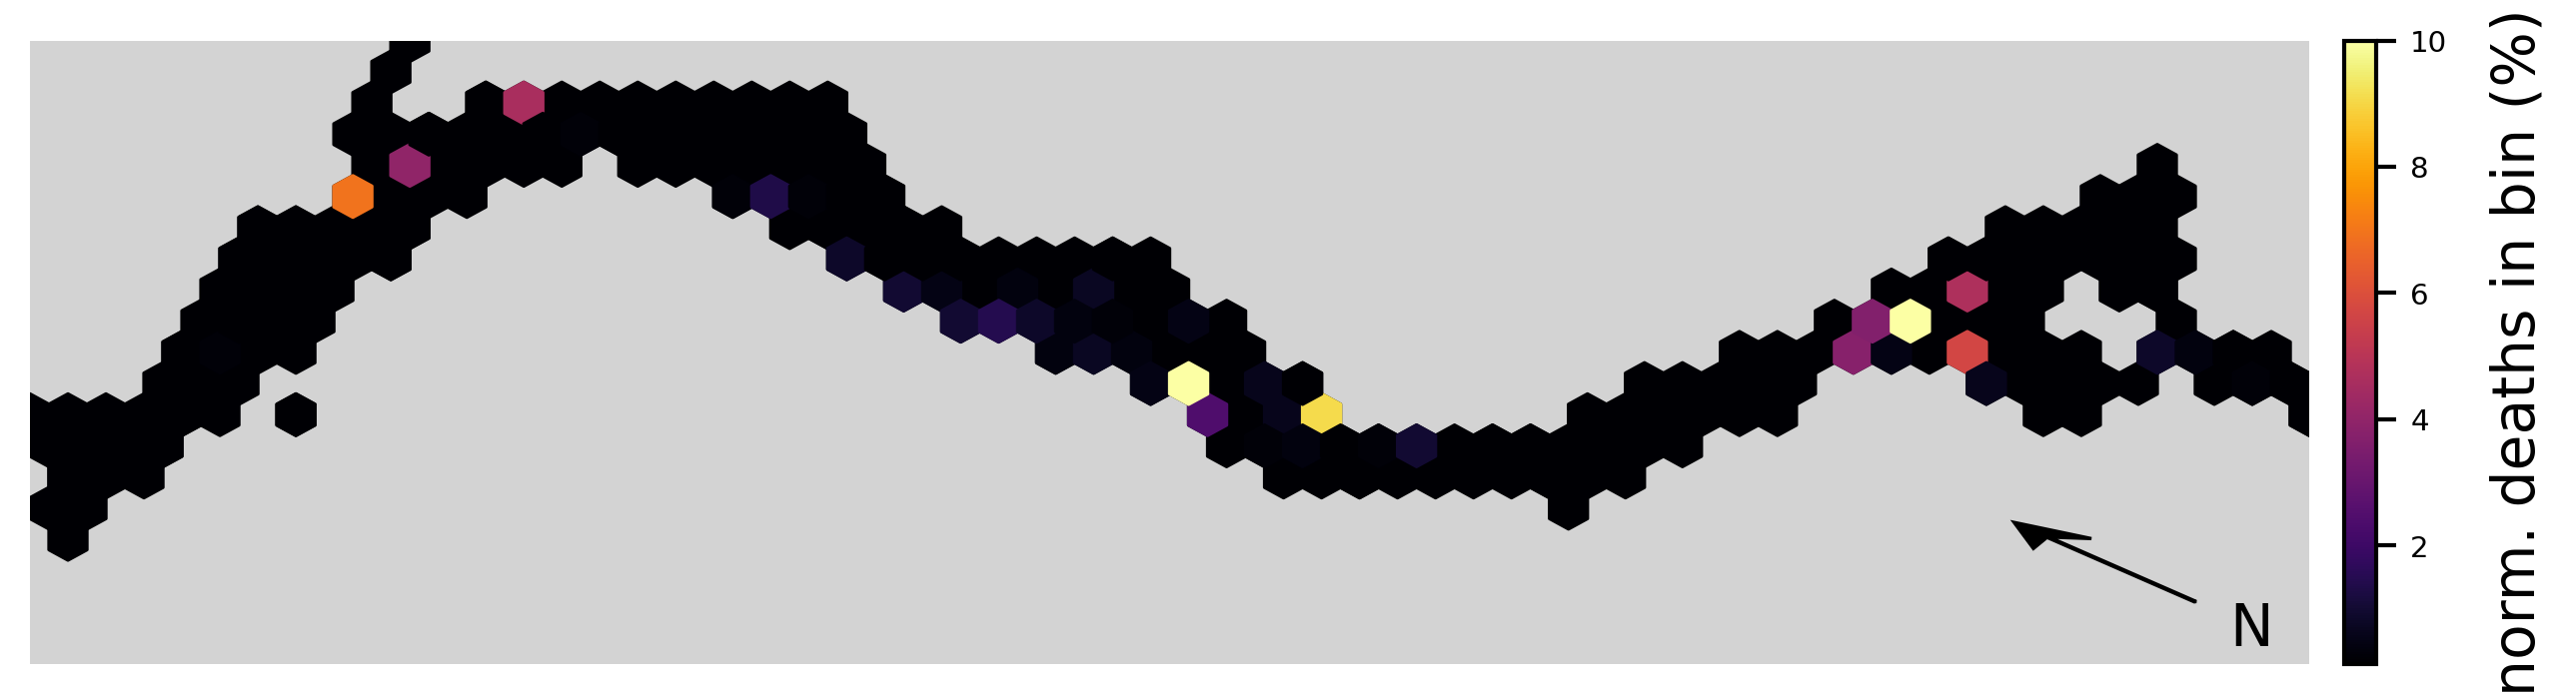

In [20]:
case_index = df[   (df['initial_size'] == 0.00005) \
    & (df['stickiness']   == 1.000000) \
    & (df['light_limitation_threshold'] == 30)
    & (df['light_limited_culling_prop'] == 3.56e-05)].index[0]


hexmap_of_death(case = cases[case_index],vmin=None,vmax=10,num_bins=10, save_path='hexmap_of_death_all_stick.png')

## v50

In [ ]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v50'

cases = get_case_info_files_from_dir(path_to_dir)
df = read_key_params_from_cases(cases)

In [ ]:
subset = slice_and_fill_subset(df, df.index, cases)

In [ ]:
# get unique set of initial sized:
initial_sizes = set(df['initial_size'])

for size in initial_sizes:

    indices = df[(df['initial_size'] == size) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index
    subset = slice_and_fill_subset(df, indices, cases)

    plot_relative_cause_for_death(subset)

In [ ]:
indices = df[(df['initial_size'] == 5e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

indices

In [ ]:
subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

In [ ]:
hexmap_of_death(cases[13],vmin=None,vmax=None,num_bins=10)

In [ ]:
hexmap_of_death(cases[1],vmin=None,vmax=None,num_bins=10)

# v48

In [ ]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v48'

cases = get_case_info_files_from_dir(path_to_dir)

In [ ]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 5e-5)].index

subset = slice_and_fill_subset(df, indices, cases)
print(subset)

plot_relative_cause_for_death(subset)

In [ ]:
hexmap_of_death(cases[2],vmin=None,vmax=None,num_bins=10)

In [ ]:
hexmap_of_death(cases[8],vmin=None,vmax=None,num_bins=10)

In [ ]:
full_column = load_concentration_data(cases[2],name='full_coloumn')

In [ ]:
top_layer = full_column

In [ ]:
_ = [print(item) for item in top_layer.keys()]

In [ ]:
x = top_layer['grid']['x'][:,0]
y = top_layer['grid']['x'][:,1]
tri = top_layer['grid']['triangles']
c = top_layer['particle_concentration']
c = np.sum(c[90:], axis=0)

In [ ]:
%matplotlib widget
plt.figure()
plt.tripcolor(x, y, tri,facecolors=c, vmax=1e-3 )
plt.colorbar()

# v44

In [ ]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v44'

cases = get_case_info_files_from_dir(path_to_dir)

In [ ]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

df

## v47

In [ ]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v47'

cases = get_case_info_files_from_dir(path_to_dir)

In [ ]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)


# v48 debug

In [ ]:
path_to_dir = '/scratch/local1/output/22_11_01_depth_losses_v48'

cases = get_case_info_files_from_dir(path_to_dir)

In [ ]:
# reading cases and sorting thru them
df = pd.DataFrame(columns=['initial_size', 'stickiness', 'light_limitation_threshold', 'light_limited_culling_prop'])

for ii, case in enumerate(cases):
    case_info = read_case_info_file(case)

    initial_size = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    stickiness = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    light_limitation_threshold = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    light_limited_culling_prop = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    df.loc[ii] = [initial_size, stickiness, light_limitation_threshold, light_limited_culling_prop]

df


In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[ (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

In [ ]:
np.linspace(0, 1, 3)

In [ ]:
df

In [ ]:
non_stick = load_track_data(cases[0])
true_stick = load_track_data(cases[2])

In [ ]:
cod = non_stick['cause_of_death'][-1]
len(cod[cod == 1]) # salinity


In [ ]:
len(cod[cod == 2]) # depth

In [ ]:
len(cod[cod == 3]) # stranding

In [ ]:
list(non_stick)

In [ ]:
df

In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

In [ ]:
# get indices of all cases with initial size 1e-5, light threshold 30 and culling 3.56e-05
indices = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)].index

subset = slice_and_fill_subset(df, indices, cases)

plot_relative_cause_for_death(subset)

In [ ]:
indices

## hexmaps of death

In [ ]:
%matplotlib inline
hexmap_of_death(cases[0],vmin=None,vmax=None)

In [ ]:
%matplotlib inline
hexmap_of_death(cases[4],vmin=None,vmax=None,num_bins=20)

## Create stickiness SA plots

 1e-5 initial size, 30 light threshold and 3.56e-05 culling

In [ ]:
# df where initial_size == 1e-5, light_limitation_threshold	== 30, light_limited_culling_prop == 3.56e-05
subset_of_cases = df[(df['initial_size'] == 1e-5) & (df['light_limitation_threshold'] == 30) & (df['light_limited_culling_prop'] == 3.56e-05)]
subset_of_cases

In [ ]:
column_names = ['radius', 'stickiness', 'illumination_threshold', 'probability_of_culling', 'cause_of_death']
cause_of_death_df = pd.DataFrame(columns=column_names)



for ii in range(len(cases)):

    case = cases[ii]
    track_data = load_track_data(case)
    case_info = read_case_info_file(case)
    
    r = case_info['full_case_params']['class_dicts']['particle_properties']['radius_spherical']['initial_value']
    a = case_info['full_case_params']['class_dicts']['particle_properties']['collision_very_fine_silt']['stickyness']
    i = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['required_illumination']
    p = case_info['full_case_params']['class_dicts']['trajectory_modifiers']['light_starvation_induced_mortality']['probability_of_culling']

    cause_of_death = track_data['cause_of_death']
    cause_of_death = cause_of_death[-1,:]

    # create subset df
    cause_of_death_subset_df = pd.DataFrame({'cause_of_death': cause_of_death})

# Repeat values of r, a, i, and p to match the length of cause_of_death
    params_subset_df = pd.DataFrame({
        column_names[0]: [r] * len(cause_of_death),
        column_names[1]: [a] * len(cause_of_death),
        column_names[2]: [i] * len(cause_of_death),
        column_names[3]: [p] * len(cause_of_death)